In [15]:
import pandas as pd

In [16]:
df = pd.read_csv("https://drive.google.com/uc?id=1qwM9kF9De5PE_-TmI9YMyLcBumTPHDD3", encoding="utf-8")

In [17]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [18]:
df.shape

(271116, 15)

In [19]:
df_filtered = df[df["Season"] == "Summer"]
df_filtered = df_filtered[~df_filtered["Medal"].isna()]
df_filtered = df_filtered[df_filtered["Year"] > 1948]
df_filtered = df_filtered.groupby(["Event", "Year"]).filter(lambda x: len(x) > 5)

In [20]:
df_filtered.shape

(16243, 15)

In [21]:
grouped_by_event = df_filtered.groupby("Event")
events = grouped_by_event.ID.apply(set).apply(list).reset_index()
events.head()

,Event,ID
0,Archery Men's Team,"[32384, 103170, 59779, 54788, 50437, 125570, 6..."
1,Archery Women's Team,"[59520, 91651, 61065, 20234, 114956, 20237, 12..."
2,Athletics Men's 4 x 100 metres Relay,"[19457, 68610, 67076, 83462, 79880, 24075, 803..."
3,Athletics Men's 4 x 400 metres Relay,"[54273, 67589, 130565, 75783, 130059, 48143, 6..."
4,Athletics Women's 4 x 100 metres Relay,"[51713, 88066, 73221, 36870, 130568, 108050, 5..."


In [22]:
exploded = events.explode("ID")
exploded.head()

,Event,ID
0,Archery Men's Team,32384
0,Archery Men's Team,103170
0,Archery Men's Team,59779
0,Archery Men's Team,54788
0,Archery Men's Team,50437


In [23]:
id_counts = exploded.ID.value_counts().to_dict()
events["total_ids"] = events["ID"].apply(len)
events["weighted_ids"] = events["ID"].apply(lambda x: sum([1 / id_counts[i] for i in x]))

In [24]:
events.head()

,Event,ID,total_ids,weighted_ids
0,Archery Men's Team,"[32384, 103170, 59779, 54788, 50437, 125570, 6...",54,54.0
1,Archery Women's Team,"[59520, 91651, 61065, 20234, 114956, 20237, 12...",62,62.0
2,Athletics Men's 4 x 100 metres Relay,"[19457, 68610, 67076, 83462, 79880, 24075, 803...",193,192.5
3,Athletics Men's 4 x 400 metres Relay,"[54273, 67589, 130565, 75783, 130059, 48143, 6...",215,214.5
4,Athletics Women's 4 x 100 metres Relay,"[51713, 88066, 73221, 36870, 130568, 108050, 5...",177,172.5


In [25]:
events["medal_value"] = events["weighted_ids"] / events["total_ids"]

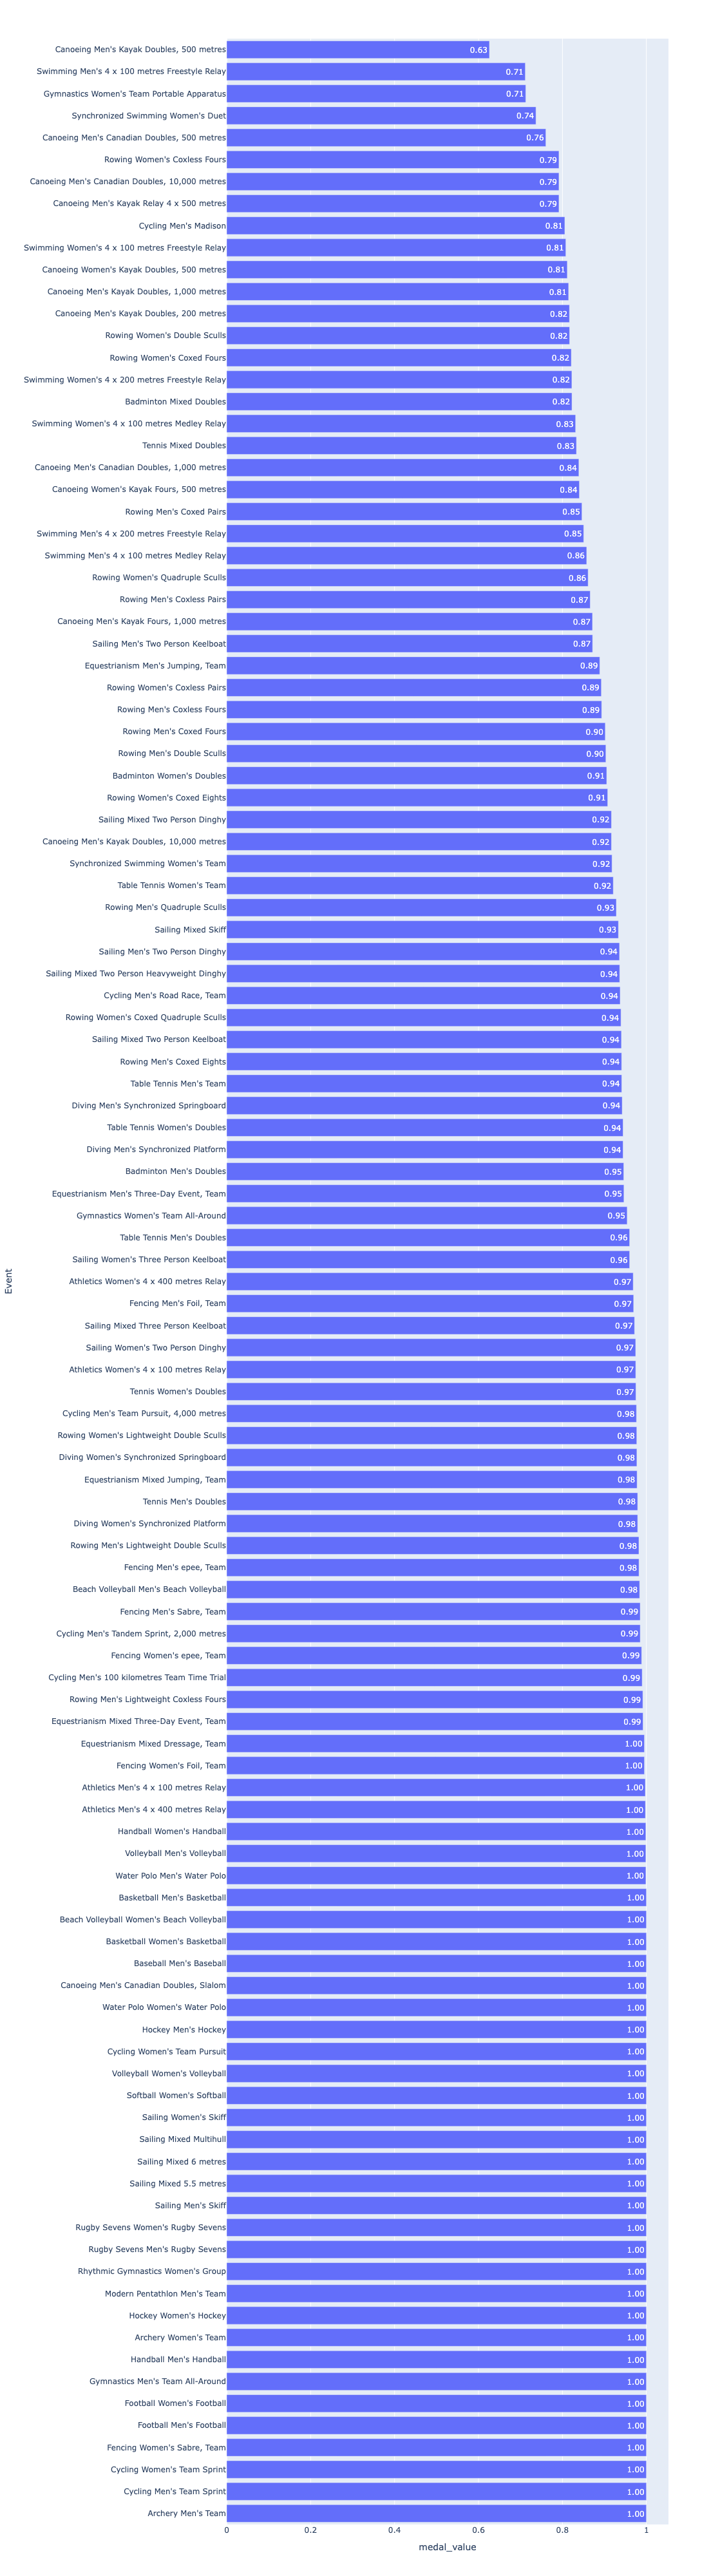

In [26]:
import plotly.express as px
df = px.data.tips()
fig = px.bar(events.sort_values("medal_value", ascending=False), x="medal_value", y="Event", text='medal_value', text_auto=",.2f", orientation='h', width=float('inf'), height=4000)
fig.show()

In [27]:
import math
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import textwrap


def text_wrapper(text: str, max_length: int = 30) -> str:
  return "<br>".join(textwrap.wrap(text, width=max_length))

cols = 6
rows =  math.ceil(len(events) / cols)
specs = [[{"type": "pie"} for i in range(cols)] for i in range(rows)]
sorted = events.sort_values("medal_value", ascending=True).reset_index()
subplot_titles = sorted.apply(lambda x: f"{text_wrapper(x.Event, 20)}<br><b>{x.medal_value:.3f}</b>", axis=1).tolist()
figs = make_subplots(rows=rows, cols=cols, specs=specs, subplot_titles=subplot_titles)

for i, event in sorted.iterrows():
  row = i // cols + 1
  col = i % cols + 1
  medal_value = event["medal_value"]
  remaining = 1 - medal_value
  rotation = 180 + remaining * 360 / 2
  pie = go.Pie(values=[medal_value, remaining], name=event["Event"], direction='clockwise', sort=True, rotation=rotation)
  figs.add_trace(pie, row=row, col=col)

figs.update_traces(textposition='none', textinfo='none', marker=dict(colors=["gold", "white"]))
figs.update_layout(height=20 * len(events), width=800, title_text="Medal value by Event", showlegend=False)
figs.update_annotations(font_size=8)

figs.show()
